<a href="https://colab.research.google.com/github/robert-sturrock/publishing-paid-me/blob/master/Publishing_paid_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive + GitHub

Mount drive and Github

In [1]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Data Projects/Publishing Paid Me'

GIT_USERNAME = "robert-sturrock" 
GIT_TOKEN = "50391de799dba17eec450691a028bc5319e4412a" 
GIT_REPOSITORY = "publishing-paid-me"    

drive.mount(ROOT)  # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)

GIT_PATH = f"https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git"
!mkdir ./tmp/publishing-paid-me
!git clone "{GIT_PATH}" ./tmp/publishing-paid-me
!mv ./tmp/publishing-paid-me/* "{PROJECT_PATH}"
!rm -r ./tmp/publishing-paid-me

# not sure what rsync is doing here. But I think it's copying the files back to the root
# !rsync -a -P --exclude=data/ "{PROJECT_PATH}"/* ./

Mounted at /content/drive
mkdir: cannot create directory ‘./tmp/publishing-paid-me’: No such file or directory
Cloning into './tmp/publishing-paid-me'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 43 (delta 14), reused 25 (delta 4), pack-reused 0
Unpacking objects: 100% (43/43), done.


# Publishing paid me

Aim of this document is to summarise and find trends in the now 1000+ entries in the Publishing Paid Me spreadsheet. Ideas for exploration include: 


Extensions: 
* Join with Goodreads review numbers as a proxy for # of sales (dataset already on Kaggle [here](https://www.kaggle.com/jealousleopard/goodreadsbooks)

In [2]:
#@title Set up code here{display-mode: "form"} 
import numpy as np
import matplotlib as m
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import re as re
import pandas as pd
import unicodedata 
import requests
import seaborn as sns
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading package for % on axis
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter

# set style
# NOTE: without this the other formatting options (eg. dpi) don't actually work
# Load packages for plotting / styling
import matplotlib.style as style
# print(plt.style.available)
import seaborn as sns
style.use('default')

In [4]:
# Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

## Functions

Set of commonly used functions for this analysis

In [5]:
def box_plot_splits(df, x):
  f,ax = plt.subplots(3, 1, figsize=(12,8))
  
  # lower outlier dataset / counts 
  tmp = df.loc[df.payment_cleaned < 200_000]
  counts = df.groupby(x).genre.count().reset_index()
  counts['percent'] = counts.genre / sum(counts.genre)
  counts = counts.sort_values(by='percent', ascending=False) 
  order = list(counts[x])

  # plots
  sns.boxplot(data=df, x=x, y='payment_cleaned', order=order, ax=ax[0])
  sns.boxplot(data=tmp, x=x, y='payment_cleaned', order=order, ax=ax[1])
  sns.barplot(data=counts, x=x, y='percent', ax=ax[2])
  plt.tight_layout()

## Load + clean data

Data stored in Drive / Github

In [6]:
file_path = f"{PROJECT_PATH}/ppm_20201010.csv"
df = pd.read_csv(file_path)

Rename all of the columns

In [7]:
cols = ['timestamp','genre','payment','rights','year','publisher','debut','agented','race','gender','sex_orient','disability','auth_name','title','comp_titles','comments']
df.columns = cols
df.head()

,timestamp,genre,payment,rights,year,publisher,debut,agented,race,gender,sex_orient,disability,auth_name,title,comp_titles,comments
0,6/11/2020 7:09:01,Academic,"$1,000",Worldwide,2018,Springer,Yes,No,White,Cis Man,Straight,No,Moorkens Castilho Gaspari Doherty,Translation Quality Assessment,NaN,NaN
1,6/7/2020 0:17:09,Academic,"$3,000",Worldwide,2019,University Press,No,Yes,White,NaN,Straight,No,NaN,NaN,NaN,NaN
2,6/9/2020 7:15:32,Academic,$0,North America Only,2011,Louisiana State University,Yes,No,White,Cis Woman,Straight,No,NaN,NaN,NaN,NaN
3,6/10/2020 9:23:46,Academic,$500,Worldwide,2013,Praeger,No,No,Multiracial,Cis Woman,Straight,No,NaN,NaN,NaN,NaN
4,6/10/2020 9:24:52,Academic,$0,Worldwide,2012,University Press,Yes,No,Multiracial,Cis Woman,Straight,No,NaN,NaN,NaN,NaN


Describe the dataset

In [8]:
df.describe()

,timestamp,genre,payment,rights,year,publisher,debut,agented,race,gender,sex_orient,disability,auth_name,title,comp_titles,comments
count,2787,2802,2802,2054,2342,2426,2297,2025,2526,2360,2012,1844,963,619,655,1195
unique,2512,215,276,51,34,216,26,4,46,10,19,5,505,607,309,859
top,6/11/2020 13:31:59,YA,"$15,000",Worldwide,2018,Small/Indie,Yes,Yes,White,Cis Woman,Straight,No,Rachel Caine,Three Thieves,No,2-book deal.
freq,15,376,176,915,376,495,1314,1634,1926,1775,1291,1619,24,2,208,33


Check for number of null values




In [9]:
df.isnull().sum().sort_values()

genre             0
payment           0
timestamp        15
race            276
publisher       376
gender          442
year            460
debut           505
rights          748
agented         777
sex_orient      790
disability      958
comments       1607
auth_name      1839
comp_titles    2147
title          2183
dtype: int64

So initially what we are seeing is that we've got complete data for genre and payment (as required by the form), and we've generally got pretty good race, gender, and publisher info. 

# EDA

## Payout

In [10]:
df.columns

Index(['timestamp', 'genre', 'payment', 'rights', 'year', 'publisher', 'debut',
       'agented', 'race', 'gender', 'sex_orient', 'disability', 'auth_name',
       'title', 'comp_titles', 'comments'],
      dtype='object')

In [11]:
df.payment.describe()

count        2802
unique        276
top       $15,000
freq          176
Name: payment, dtype: object

In [12]:
df.payment.describe()

count        2802
unique        276
top       $15,000
freq          176
Name: payment, dtype: object

In [13]:
df['payment_cleaned'] = df.payment.str.replace('$','')
df['payment_cleaned'] = df.payment_cleaned.str.replace(',','').astype('float')
df.payment_cleaned.describe()

count      2802.000
mean      49382.034
std      138888.514
min        -100.000
25%        5500.000
50%       18000.000
75%       45000.000
max     3000000.000
Name: payment_cleaned, dtype: float64

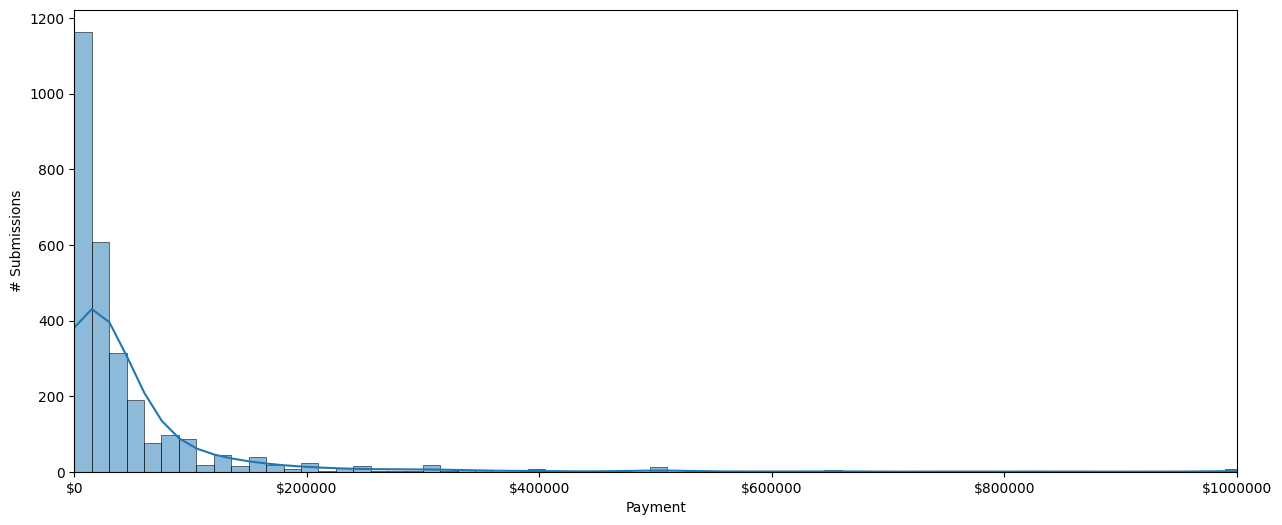

In [14]:
f,ax = plt.subplots(figsize=(15,6))
sns.histplot(data=df, x=df.payment_cleaned, kde=True, bins=200, ax=ax)

# Labels:
ax.set_xlabel('Payment')
ax.set_ylabel('# Submissions')

# formatting
ax.set_xlim(0,1_000_000)
formatter_dollar = mtick.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter_dollar)



Let's do a zoomed in version on just the lower end of the distribution

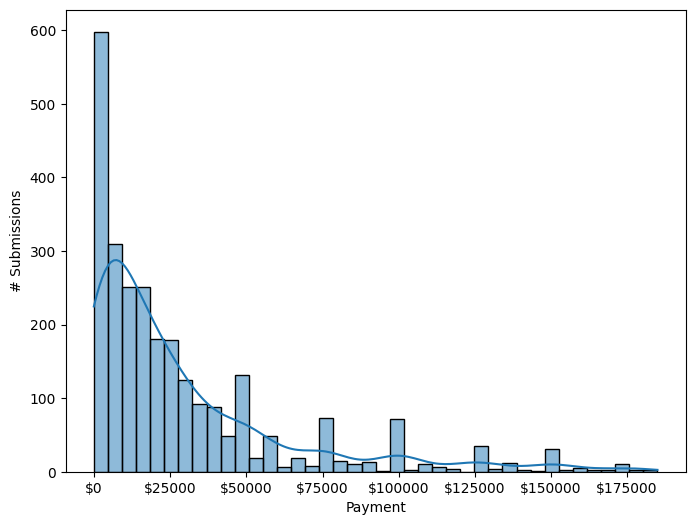

In [15]:
f,ax = plt.subplots(figsize=(8,6))

# plot:
tmp = df.loc[df.payment_cleaned < 200_000]
sns.histplot(data=tmp, x='payment_cleaned', kde=True, bins=40, ax=ax)

# labels:
ax.set_xlabel('Payment')
ax.set_ylabel('# Submissions')

# formatting
formatter_dollar = mtick.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter_dollar)

Key finding here: most offers per book are low, but publishers really like round numbers (spikes at 50k, 75k, 100k, 125k, 150k, 175k per book)

## Genre

Let's get a better sense of the data itself. First, what are the most popular genres?

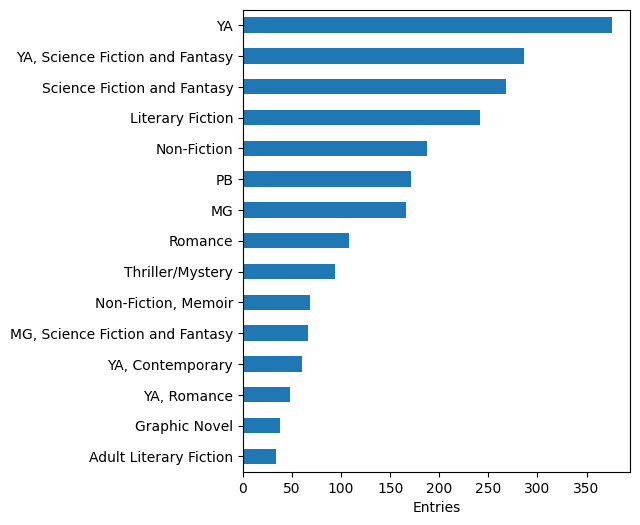

In [16]:
f,ax = plt.subplots(figsize=(5,6))

tmp = df.genre.value_counts().reset_index().head(15)
tmp = tmp.sort_values(by='genre', ascending=True)
tmp.plot.barh(x='index', ax=ax)

# Labels:
ax.set_xlabel('Entries')
ax.set_ylabel('')

# Legend
ax.get_legend().remove()

Main takeaway from here: I've probably got to create a high level flag variable.

In [17]:
pd.set_option('display.max_rows', 250)


In [18]:
tmp = df.genre.value_counts().reset_index()
tmp.loc[tmp.genre > 1]

,index,genre
0,YA,376
1,"YA, Science Fiction and Fantasy",286
2,Science Fiction and Fantasy,268
3,Literary Fiction,242
4,Non-Fiction,188
5,PB,171
6,MG,166
7,Romance,108
8,Thriller/Mystery,94
9,"Non-Fiction, Memoir",68


In [19]:
def top_genre(row):
  if 'PB' in row['genre']: 
    return 'Picture Book'
  if 'YA' in row['genre']:
    return 'YA'
  if 'Science' in row['genre']:
    return 'Sci-Fi Fantasy'
  if 'Literary' in row['genre']:
    return 'Literary'
  if 'MG' in row['genre']:
    return 'MG'
  if 'Romance' in row['genre']:
    return 'Romance'
  if 'Thriller' in row['genre']: 
    return 'Thriller/Mystery'
  if 'Non-Fiction' in row['genre']: 
    return 'Non-Fiction'
  else:
    return 'Other'

In [20]:
# apply genre cleaning and view categories
df['genre_clean'] = df.apply(top_genre, axis=1)
df.genre_clean.value_counts()

YA                  922
Sci-Fi Fantasy      386
Literary            321
Non-Fiction         292
MG                  226
Picture Book        211
Other               194
Romance             148
Thriller/Mystery    102
Name: genre_clean, dtype: int64

Now we want to look at payout by genre, and the range of payouts

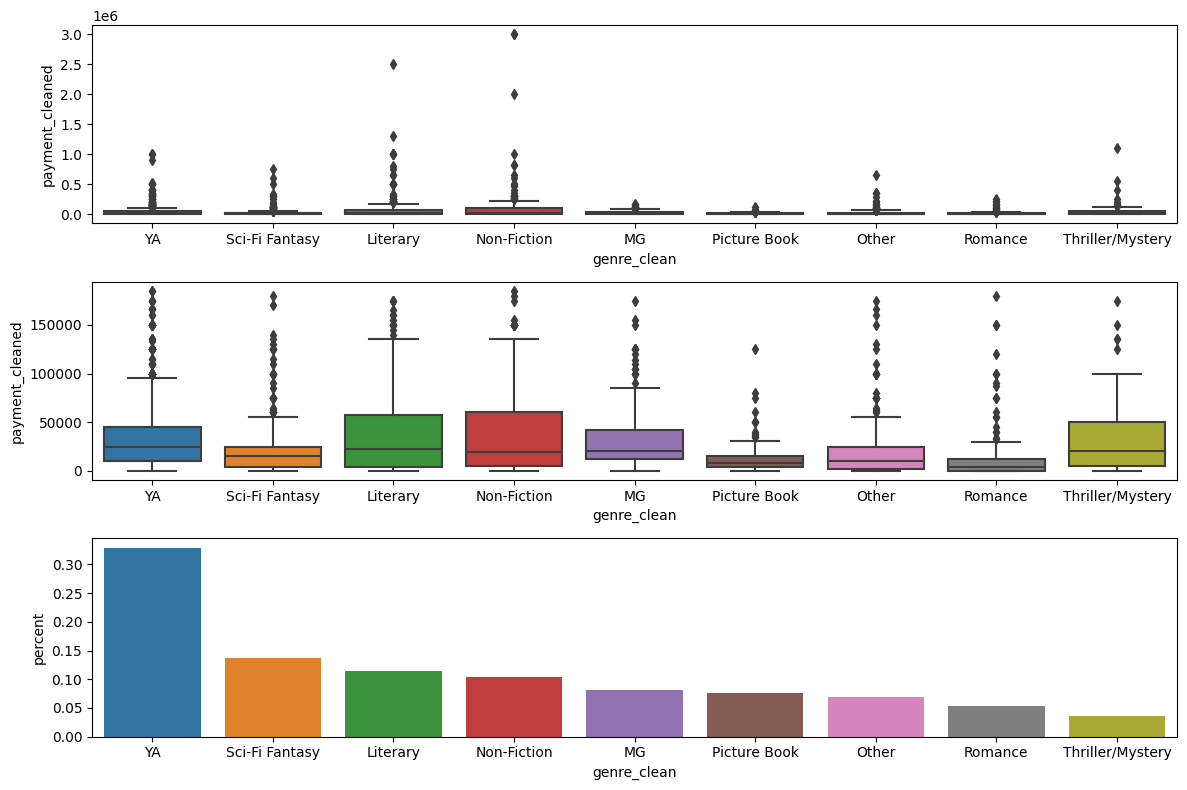

In [21]:
box_plot_splits(df, x='genre_clean')

## Publisher data

We know one of the big divides is between how much the Big 5 publishers will pay and how much independant presses will pay. Let's look at what proportion of sales are to big 5, and what the average payment differences are

In [22]:
df.publisher.nunique()

216

In [23]:
df.publisher.value_counts().head(40)

Small/Indie                            495
Penguin Random House (and Imprints)    293
Large (Big 5)                          265
Mid-Size (Scholastic, Disney, etc)     239
HarperCollins (and Imprints)           235
Macmillan (and Imprints)               214
Hachette (and Imprints)                116
Simon & Schuster (and Inprints)         96
Simon & Schuster (and Imprints)         57
Balzer + Bray                           12
Bloomsbury                              12
Sourcebooks                             12
Simon Pulse                             10
Amazon Publishing                       10
Self-Pub                                 9
Nobrow                                   8
Scholastic                               7
Swoon Reads                              7
University Press                         7
Disney                                   7
Tor                                      6
Flux                                     6
Page Street                              6
HarperColli

In [24]:
# first get rid of all Nan values
df['publisher'] = df.publisher.fillna(value='Not listed')

In [25]:
def top_publisher(row): 
  large_pubs = ['Large','Penguin','HarperCollins','Macmillan','Hachette','Simon']
  mid_pubs = ['Mid-Size','Disney','Scholastic']
  small_pubs = ['Small','Sourcebooks']

  # replace all NaN values
  if any(pub in row['publisher'] for pub in small_pubs):
    return 'Small/Indie'
  if any(pub in row['publisher'] for pub in mid_pubs):
    return 'Mid-Size'
  if any(pub in row['publisher'] for pub in large_pubs):
    return 'Big 5'
  else: 
    return 'Other'

In [26]:
df['publisher_clean'] = df.apply(top_publisher, axis=1)

In [27]:
df.publisher_clean.value_counts()

Big 5          1303
Other           730
Small/Indie     510
Mid-Size        259
Name: publisher_clean, dtype: int64

Unfortunately there's quite a bit of sorting that would need to be done in order to properly capture that long tail of imprints. But hopefully the well categorized top is good enough

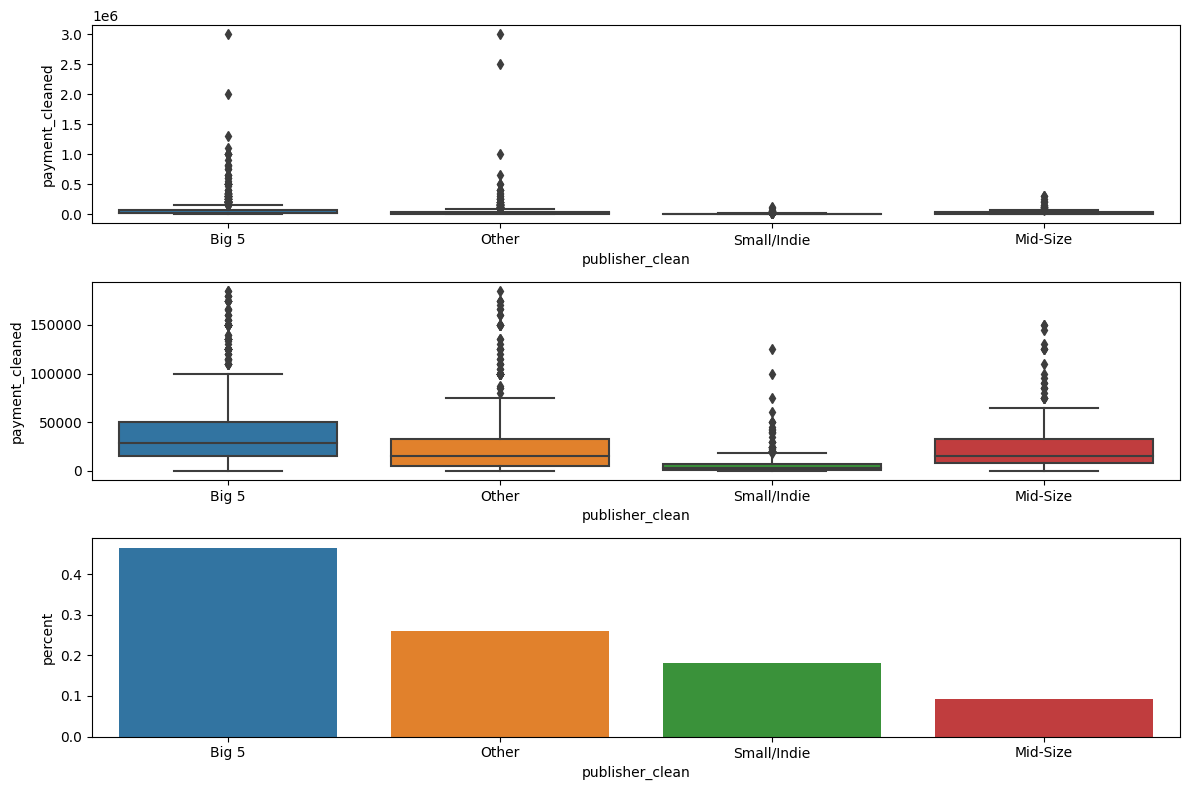

In [28]:
box_plot_splits(df, x='publisher_clean')

## Gender / race

Basic analysis across different categories. Start first by making the race data more managable / easy to visualise on charts



In [29]:
df.head()

,timestamp,genre,payment,rights,year,publisher,debut,agented,race,gender,sex_orient,disability,auth_name,title,comp_titles,comments,payment_cleaned,genre_clean,publisher_clean
0,6/11/2020 7:09:01,Academic,"$1,000",Worldwide,2018,Springer,Yes,No,White,Cis Man,Straight,No,Moorkens Castilho Gaspari Doherty,Translation Quality Assessment,NaN,NaN,1000.000,Other,Other
1,6/7/2020 0:17:09,Academic,"$3,000",Worldwide,2019,University Press,No,Yes,White,NaN,Straight,No,NaN,NaN,NaN,NaN,3000.000,Other,Other
2,6/9/2020 7:15:32,Academic,$0,North America Only,2011,Louisiana State University,Yes,No,White,Cis Woman,Straight,No,NaN,NaN,NaN,NaN,0.000,Other,Other
3,6/10/2020 9:23:46,Academic,$500,Worldwide,2013,Praeger,No,No,Multiracial,Cis Woman,Straight,No,NaN,NaN,NaN,NaN,500.000,Other,Other
4,6/10/2020 9:24:52,Academic,$0,Worldwide,2012,University Press,Yes,No,Multiracial,Cis Woman,Straight,No,NaN,NaN,NaN,NaN,0.000,Other,Other


In [30]:
df.groupby('race').payment_cleaned.agg(['mean','count']).reset_index().sort_values(by='count', ascending=False).head(30)

,race,mean,count
44,White,42099.193,1926
4,Black,97863.896,134
11,East Asian,77724.828,116
28,Multiracial,63525.178,73
21,Latin American,38274.746,59
17,Indian/South Asian,35480.804,56
39,Southeast Asian,49440.421,38
0,Arab/West Asian/Middle Eastern,24694.444,18
32,Nonwhite,47750.000,12
29,Native American/First Nations,94777.778,9


So a number of these categories overlap. In order to make it easier to actually see the results we are going to group together any categories with multiple as "Multiracial". 

I'm also going to one that is just "White, Black, and Other" - and look at the ranges

In [31]:
def white_black_other(row):
  if row['race'] in ('White','Black'):
    return row['race']
  else:
    return 'Other'

In [32]:
type(df.race)

pandas.core.series.Series

In [33]:
# fill in nan values which cause errors
df['race'] = df.race.fillna(value='Not specified')

In [34]:
def race_group(row):
  if row['race'] in ('White','Black'):
    return row['race']
  if ',' in row['race'] or row['race']=='Multiracial':
    return "Multiracial"
  if 'Asian' in row['race']:
    return 'Asian'
  if 'Latin American' in row['race']:
    return 'Latin American'
  else:
    return 'Other'

In [35]:
df['race_group'] = df.apply(white_black_other, axis=1)
df['race_group_detail'] = df.apply(race_group, axis=1)


In [36]:
df.race_group.value_counts()

White    1926
Other     742
Black     134
Name: race_group, dtype: int64

In [37]:
df.race_group_detail.value_counts()

White             1926
Other              303
Asian              229
Multiracial        151
Black              134
Latin American      59
Name: race_group_detail, dtype: int64

Let's look at the how the distribution of payment looks for these different groups of writers

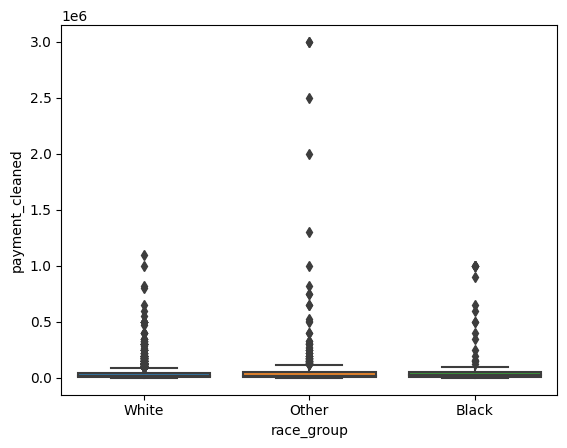

In [38]:
sns.boxplot(data=df, y='payment_cleaned',x='race_group')

Truncate the results so that we don't have as wide outliers

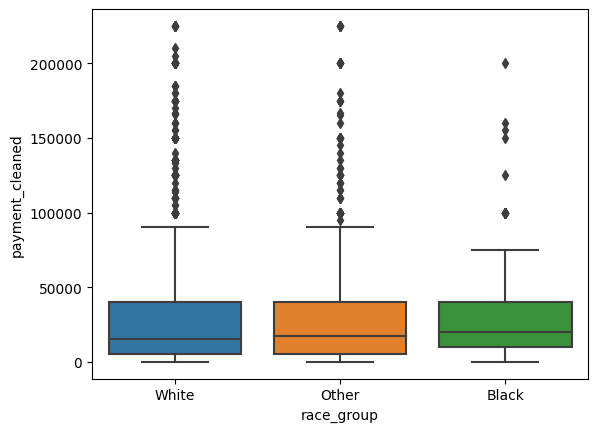

In [39]:
tmp = df.loc[df.payment_cleaned < 250_000]
sns.boxplot(data=tmp, y='payment_cleaned',x='race_group')

That's a bit surprising - seems like the distributions are very similar - black writers are just missing out on some of the larger deals, but it looks more like an artifact of having fewer observations

In [40]:
df.groupby('race_group').payment_cleaned.mean()

race_group
Black   97863.896
Other   59530.530
White   42099.193
Name: payment_cleaned, dtype: float64

In [41]:
df.groupby('race_group').payment_cleaned.median()

race_group
Black   25000.000
Other   19000.000
White   17500.000
Name: payment_cleaned, dtype: float64

But we also need to make this a bit easier to understand. I'm going to create a bucketed version of this for the three categories 

In [42]:
df['payment_category'] = pd.cut(df.payment_cleaned, 
                                bins = (-101,10_000, 20_000, 30_000, 50_000, 100_000, 5_000_000), 
                                labels = ['0-$10k','$10k-$20k','$20k-$30k','$30k-$50k','$50k-$100k','$100k+'], 
                                include_lowest = True) 

In [43]:
df.payment_category.describe()

count       2802
unique         6
top       0-$10k
freq        1062
Name: payment_category, dtype: object

In [44]:
df.payment_category.value_counts()

0-$10k        1062
$10k-$20k      505
$30k-$50k      364
$20k-$30k      322
$50k-$100k     282
$100k+         267
Name: payment_category, dtype: int64

In [45]:
df.payment_cleaned.describe()

count      2802.000
mean      49382.034
std      138888.514
min        -100.000
25%        5500.000
50%       18000.000
75%       45000.000
max     3000000.000
Name: payment_cleaned, dtype: float64

In [46]:
# Let's look at 
tmp = (df.groupby(['race_group','payment_category']).payment_cleaned.count() / 
        df.groupby(['race_group']).payment_cleaned.count())

tmp


race_group  payment_category
Black       0-$10k             0.254
            $10k-$20k          0.224
            $20k-$30k          0.112
            $30k-$50k          0.179
            $50k-$100k         0.097
            $100k+             0.134
Other       0-$10k             0.379
            $10k-$20k          0.178
            $20k-$30k          0.102
            $30k-$50k          0.151
            $50k-$100k         0.100
            $100k+             0.090
White       0-$10k             0.388
            $10k-$20k          0.178
            $20k-$30k          0.120
            $30k-$50k          0.118
            $50k-$100k         0.101
            $100k+             0.094
Name: payment_cleaned, dtype: float64

In [47]:
tmp.reset_index().groupby('race_group').payment_cleaned.sum()

race_group
Black   1.000
Other   1.000
White   1.000
Name: payment_cleaned, dtype: float64

Plot the distributions in vertical bar space

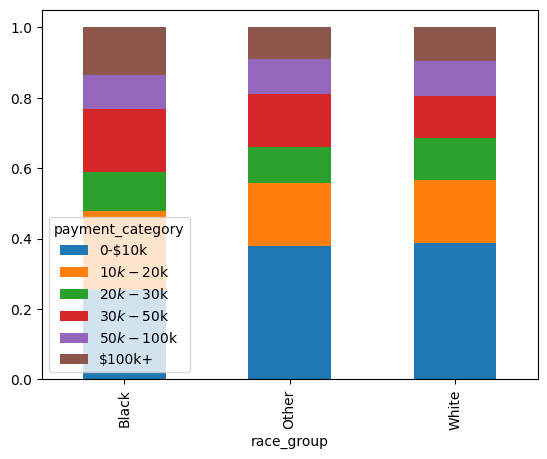

In [48]:
tmp.unstack().plot.bar(stacked=True)

## Genre + Race - automated charts

Let's now try and look at how race and genre vary acorss the the different genres. We want to get a sense if maybe the mix of genres actually impacts the top line race statistics (eg. if Black authors publish in more lucrative genres they may look like they are paid more than White writers - while actually still being paid less in every genre they publish in).

In [49]:
def automated_bars(df, chart_cat, bar_cat): 
  
  # number of charts
  chart_cats = list(df['chart_cat'].unique())

  f, ax = plt.subplots()

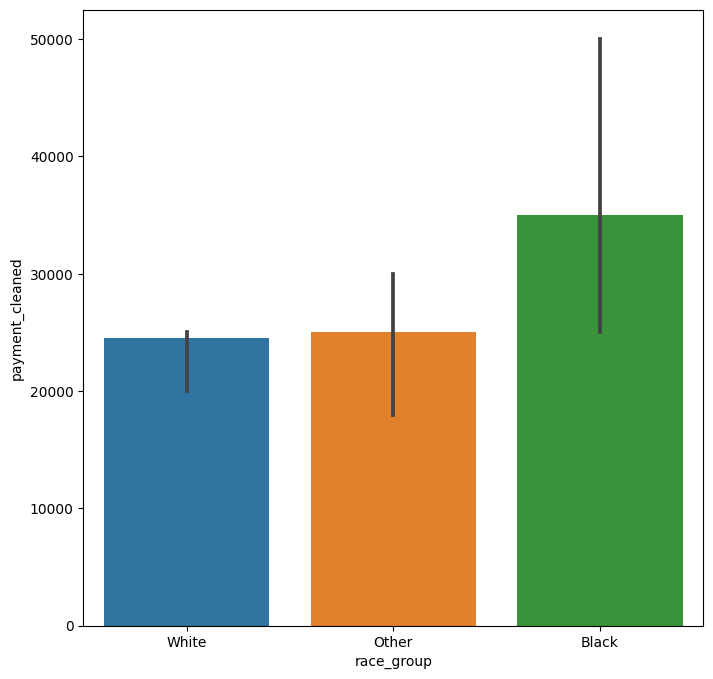

In [50]:

f, ax = plt.subplots(1,1,figsize=(8,8))

chart_cat = 'YA'
tmp = df.loc[df['genre']==chart_cat]

sns.barplot(data=tmp, x='race_group', y='payment_cleaned', estimator=np.median)

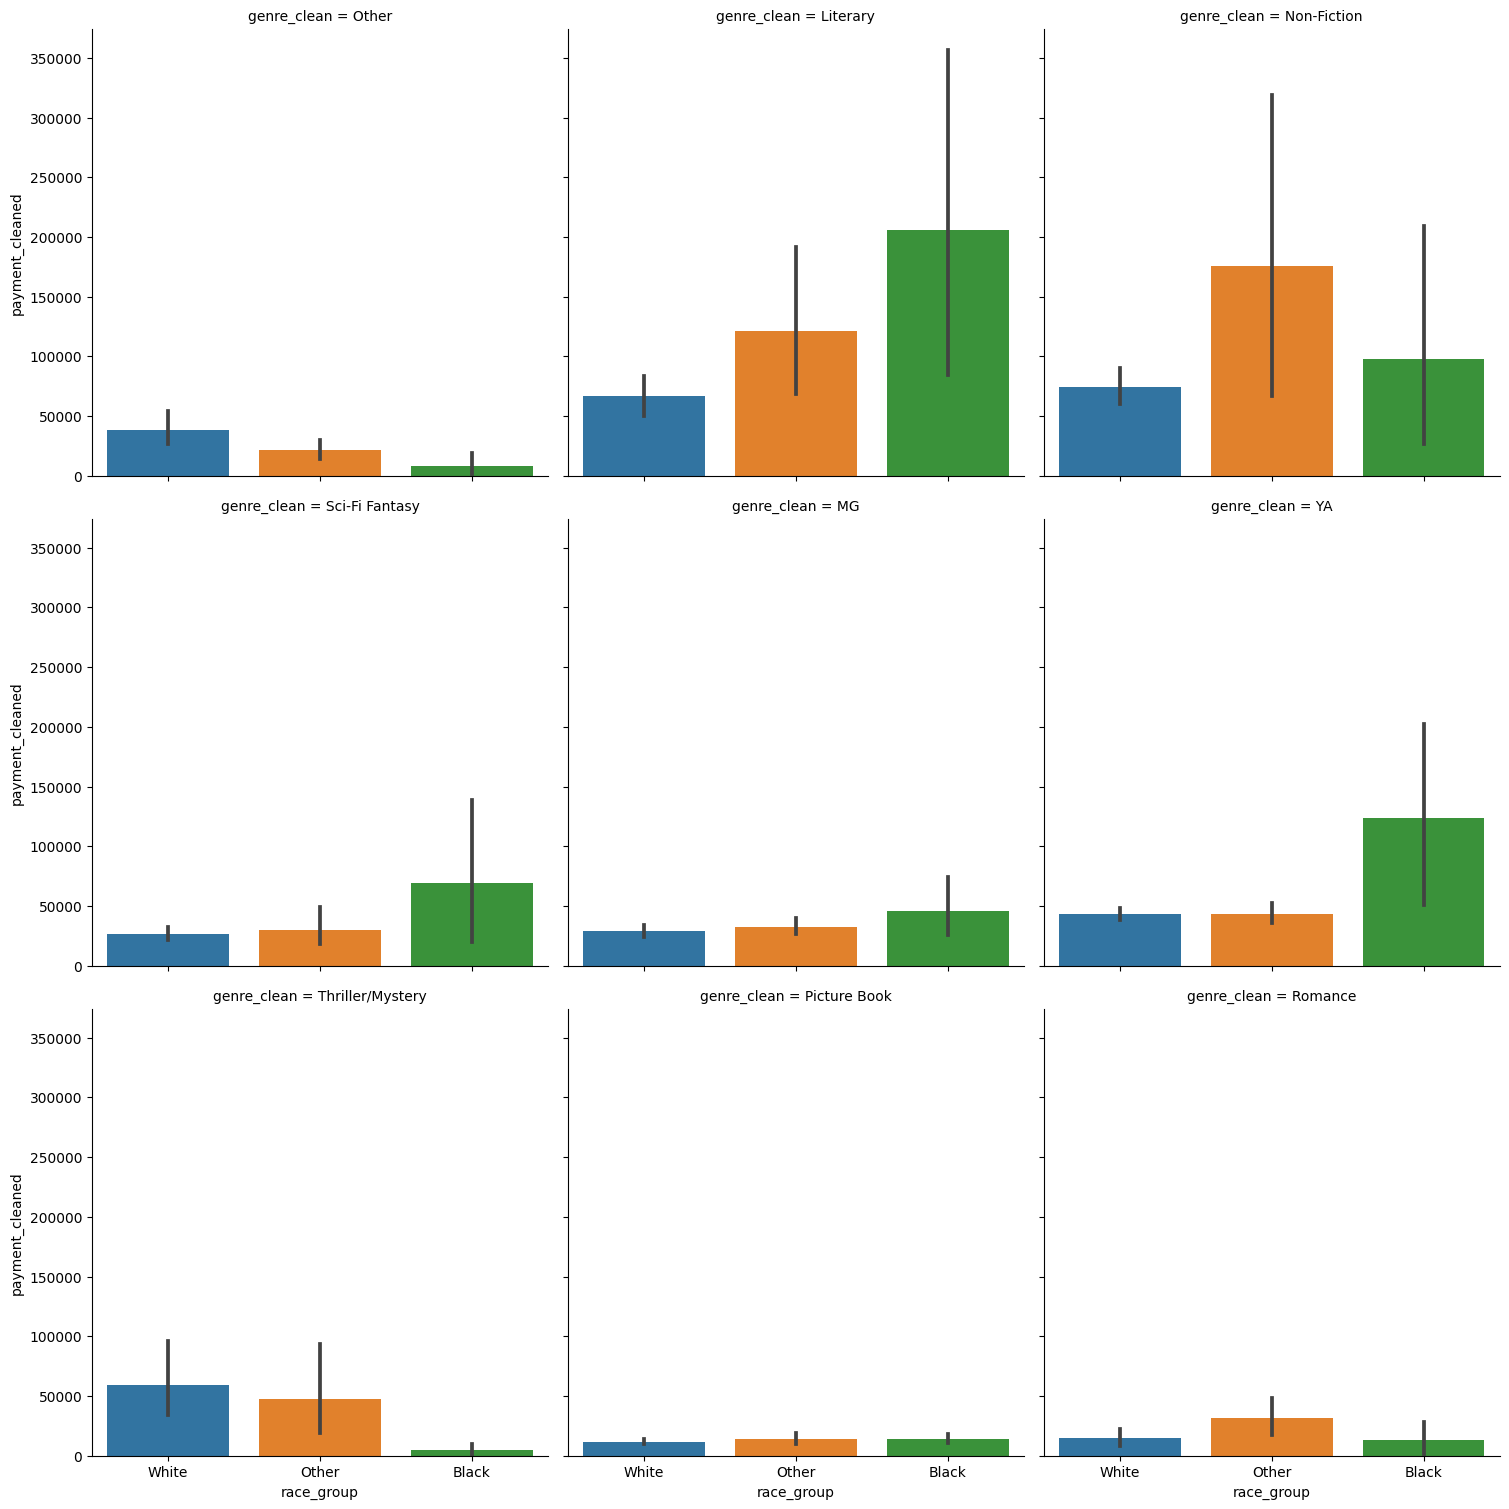

In [51]:
sns.catplot(x='race_group', y='payment_cleaned',col='genre_clean',data=df,kind='bar', col_wrap=3)

# Title + Goodreads data

Aim of this is to look at how advance relates to Goodreads reviews (as a proxy for sales / reach of the book). 

In [52]:
titles = df.loc[~df.title.isna()]

In [53]:
titles.head(10)

,timestamp,genre,payment,rights,year,publisher,debut,agented,race,gender,sex_orient,disability,auth_name,title,comp_titles,comments,payment_cleaned,genre_clean,publisher_clean,race_group,race_group_detail,payment_category
0,6/11/2020 7:09:01,Academic,"$1,000",Worldwide,2018,Springer,Yes,No,White,Cis Man,Straight,No,Moorkens Castilho Gaspari Doherty,Translation Quality Assessment,NaN,NaN,1000.000,Other,Other,White,White,0-$10k
6,6/10/2020 15:30:39,Adult Literary Fiction,"$285,000",English Language Only,2018,HarperCollins (and Imprints),Yes,Yes,White,Cis Woman,Demi/Asexual,No,Jamey Bradbury,The Wild Inside,NaN,NaN,285000.000,Literary,Big 5,White,White,$100k+
7,6/10/2020 16:11:32,Adult Literary Fiction,"$25,000",NaN,2016,St. Martin's Press,Yes,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,People Who Knew Me,NaN,NaN,25000.000,Literary,Other,Other,Other,$20k-$30k
8,6/10/2020 16:11:32,Adult Literary Fiction,"$5,000",NaN,2018,Turner,No,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,Cherry Blossoms,NaN,NaN,5000.000,Literary,Other,Other,Other,0-$10k
9,6/10/2020 16:11:32,Adult Literary Fiction,"$5,000",NaN,2019,Turner,No,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,Tiny,NaN,NaN,5000.000,Literary,Other,Other,Other,0-$10k
10,6/10/2020 15:55:15,Adult Literary Fiction,"$75,000",North America Only,2013,Macmillan (and Imprints),Yes,Yes,"East Asian, White, Multiracial",Cis Woman,Straight,No,Naomi J. Williams,Landfalls,NaN,at-auction,75000.000,Literary,Big 5,Other,Multiracial,$50k-$100k
46,6/9/2020 12:47:18,Anthology,"$30,000",English Language Only,2017,Simon & Schuster (and Imprints),I was editor of the anthology; it was my first...,Yes,White,Cis Woman,Straight,No,Manjula Martin,"Scratch: Writers, Money, and the Art of Making...","MFA vs. NYC, Goodbye to All That",30K advance for an anthology with 24 contribut...,30000.000,Other,Big 5,White,White,$20k-$30k
47,6/7/2020 23:54:06,Anthology,"$20,000",NaN,2020,Running Press,NaN,NaN,Not specified,NaN,NaN,NaN,Rebecca Podos,Fools in Love,NaN,Split.,20000.000,Other,Other,Other,Other,$10k-$20k
49,6/9/2020 9:57:14,"Anthology, ""Erotic"" Fanfic","$10,000",North America Only,2016,Hachette (and Imprints),Yes,No,White,Cis Woman,"Bi/Pansexual, Queer",No,Amy Stephenson,Loose Lips,No,"Big names in the anthology, NYT bestsellers etc.",10000.000,Other,Big 5,White,White,0-$10k
50,6/7/2020 9:06:05,"Anthology, Literary Fiction","$10,000",North America Only,2020,&NOW books,Yes,No,White,Nonbinary/Agender,Queer,NaN,JD Scott,"Moonflower, Nightshade, All the Hours of the Day",NaN,Technically fellowship money and not an advanc...,10000.000,Literary,Other,White,White,0-$10k


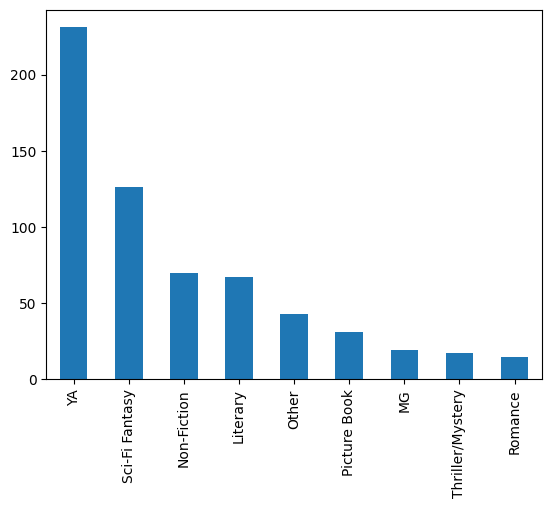

In [54]:
titles.genre_clean.value_counts().plot.bar()

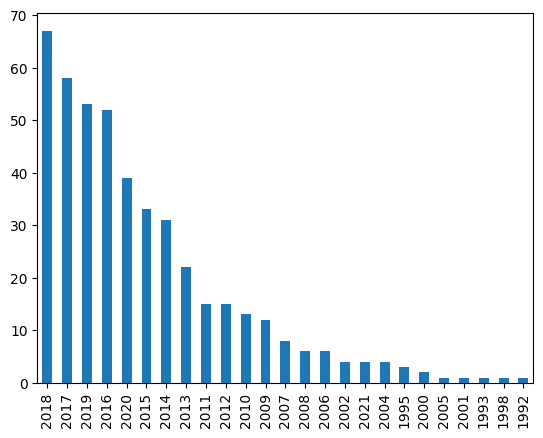

In [55]:
titles.year.value_counts().plot.bar()

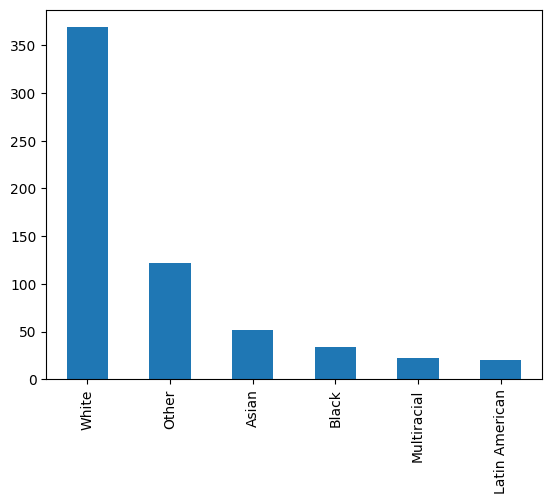

In [56]:
titles.race_group_detail.value_counts().plot.bar()

## Load data from GitHub / Drive

In [59]:
dataframes = list()

for num in range(0,4):
  drive_file = f"{PROJECT_PATH}/goodreads_data_{num} (1).csv"
  df = pd.read_csv(drive_file)
  dataframes.append(df)

gr = pd.concat(dataframes)

In [60]:
gr.columns

Index(['Unnamed: 0', 'search_term', 'title', 'author', 'publisher',
       'ratings_count', 'average_rating', 'pub_date', 'pub_year'],
      dtype='object')

Next we need to join this with our Publishing Paid me dataset, where we are hoping to match on the titles

In [61]:
gr.head()

,Unnamed: 0,search_term,title,author,publisher,ratings_count,average_rating,pub_date,pub_year
0,0,Translation Quality Assessment Moorkens Castil...,Translation Quality Assessment: From Principle...,Joss Moorkens,Springer,1,5.000,"('9', '12', '2018')",2018.000
1,1,Translation Quality Assessment Moorkens Castil...,Translation Quality Assessment: From Principle...,Joss Moorkens,NaN,0,0.000,"(None, None, None)",nan
2,0,The Wild Inside Jamey Bradbury,The Wild Inside,Jamey Bradbury,William Morrow,574,3.290,"('3', '20', '2018')",2018.000
3,0,People Who Knew Me Kim Hooper,People Who Knew Me,Kim Hooper,St. Martin's Press,925,3.990,"('5', '24', '2016')",2016.000
4,0,Cherry Blossoms Kim Hooper,Cherry Blossoms,Kim Hooper,Turner,26,4.300,"('10', '30', '2018')",2018.000


In [62]:
titles.head(5)

,timestamp,genre,payment,rights,year,publisher,debut,agented,race,gender,sex_orient,disability,auth_name,title,comp_titles,comments,payment_cleaned,genre_clean,publisher_clean,race_group,race_group_detail,payment_category
0,6/11/2020 7:09:01,Academic,"$1,000",Worldwide,2018,Springer,Yes,No,White,Cis Man,Straight,No,Moorkens Castilho Gaspari Doherty,Translation Quality Assessment,NaN,NaN,1000.000,Other,Other,White,White,0-$10k
6,6/10/2020 15:30:39,Adult Literary Fiction,"$285,000",English Language Only,2018,HarperCollins (and Imprints),Yes,Yes,White,Cis Woman,Demi/Asexual,No,Jamey Bradbury,The Wild Inside,NaN,NaN,285000.000,Literary,Big 5,White,White,$100k+
7,6/10/2020 16:11:32,Adult Literary Fiction,"$25,000",NaN,2016,St. Martin's Press,Yes,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,People Who Knew Me,NaN,NaN,25000.000,Literary,Other,Other,Other,$20k-$30k
8,6/10/2020 16:11:32,Adult Literary Fiction,"$5,000",NaN,2018,Turner,No,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,Cherry Blossoms,NaN,NaN,5000.000,Literary,Other,Other,Other,0-$10k
9,6/10/2020 16:11:32,Adult Literary Fiction,"$5,000",NaN,2019,Turner,No,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,Tiny,NaN,NaN,5000.000,Literary,Other,Other,Other,0-$10k


Join the data

In [63]:
gr_merge = titles.merge(gr, how='left', left_on=['title','auth_name'], right_on=['title','author'])

In [64]:
gr_merge.head()

,timestamp,genre,payment,rights,year,publisher_x,debut,agented,race,gender,sex_orient,disability,auth_name,title,comp_titles,comments,payment_cleaned,genre_clean,publisher_clean,race_group,race_group_detail,payment_category,Unnamed: 0,search_term,author,publisher_y,ratings_count,average_rating,pub_date,pub_year
0,6/11/2020 7:09:01,Academic,"$1,000",Worldwide,2018,Springer,Yes,No,White,Cis Man,Straight,No,Moorkens Castilho Gaspari Doherty,Translation Quality Assessment,NaN,NaN,1000.000,Other,Other,White,White,0-$10k,nan,NaN,NaN,NaN,nan,nan,NaN,nan
1,6/10/2020 15:30:39,Adult Literary Fiction,"$285,000",English Language Only,2018,HarperCollins (and Imprints),Yes,Yes,White,Cis Woman,Demi/Asexual,No,Jamey Bradbury,The Wild Inside,NaN,NaN,285000.000,Literary,Big 5,White,White,$100k+,0.000,The Wild Inside Jamey Bradbury,Jamey Bradbury,William Morrow,574.000,3.290,"('3', '20', '2018')",2018.000
2,6/10/2020 16:11:32,Adult Literary Fiction,"$25,000",NaN,2016,St. Martin's Press,Yes,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,People Who Knew Me,NaN,NaN,25000.000,Literary,Other,Other,Other,$20k-$30k,0.000,People Who Knew Me Kim Hooper,Kim Hooper,St. Martin's Press,925.000,3.990,"('5', '24', '2016')",2016.000
3,6/10/2020 16:11:32,Adult Literary Fiction,"$5,000",NaN,2018,Turner,No,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,Cherry Blossoms,NaN,NaN,5000.000,Literary,Other,Other,Other,0-$10k,0.000,Cherry Blossoms Kim Hooper,Kim Hooper,Turner,26.000,4.300,"('10', '30', '2018')",2018.000
4,6/10/2020 16:11:32,Adult Literary Fiction,"$5,000",NaN,2019,Turner,No,NaN,Not specified,NaN,NaN,NaN,Kim Hooper,Tiny,NaN,NaN,5000.000,Literary,Other,Other,Other,0-$10k,0.000,Tiny Kim Hooper,Kim Hooper,Turner,66.000,4.120,"(None, None, '2019')",2019.000


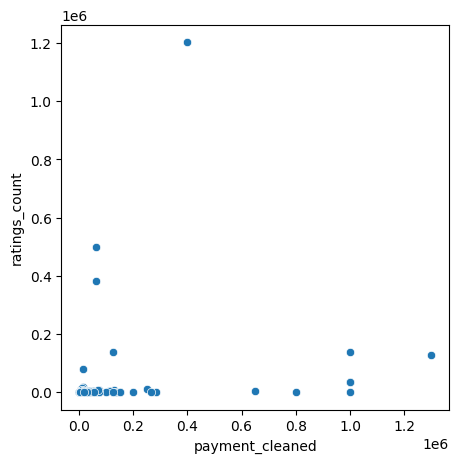

In [65]:
f,ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=gr_merge, x='payment_cleaned', y='ratings_count', ax=ax)



(0.0, 10000.0)

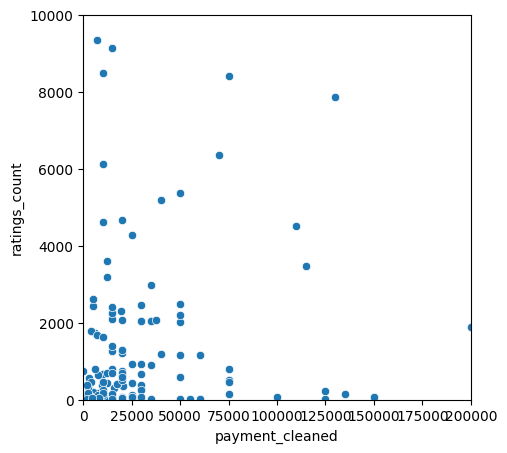

In [66]:
f,ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=gr_merge, x='payment_cleaned', y='ratings_count', ax=ax)

ax.set_xlim(0,200_000)
ax.set_ylim(0,10_000)

It looks like there  is probably a decent amount of cleaning work to do here before we have a clean picture.

## Sorting out merge issues

In [67]:
vars = ['title','author','genre','payment_cleaned','ratings_count']
gr_merge.loc[gr_merge.payment_cleaned>200_000, vars]

,title,author,genre,payment_cleaned,ratings_count
1,The Wild Inside,Jamey Bradbury,Adult Literary Fiction,285000.000,574.000
51,Cape May,Chip Cheek,Literary Fiction,800000.000,255.000
57,The Girls (+ two additional books),NaN,Literary Fiction,333333.000,nan
59,Behold the Dreamers,Imbolo Mbue,Literary Fiction,1000000.000,35770.000
60,American Dirt,Jeanine Cummins,Literary Fiction,1300000.000,126888.000
75,You Know You Want This,Kristen Roupenian,Literary Fiction,650000.000,4869.000
76,The Secrets We Kept,Lara Prescott,Literary Fiction,1000000.000,35955.000
86,The Refugees,Viet Thanh Nguyen,Literary Fiction,250000.000,12264.000
87,Homegoing,Yaa Gyasi,Literary Fiction,1000000.000,138964.000
127,The Eagles of Heart Mountain,NaN,Non-Fiction,300000.000,nan


In [68]:
gr.loc[gr.search_term.str.contains('The Eagles of Heart', na=False)]

,Unnamed: 0,search_term,title,author,publisher,ratings_count,average_rating,pub_date,pub_year
160,0,The Eagles of Heart Mountain Bradford Pearson,The Eagles of Heart Mountain: A True Story of ...,Bradford Pearson,Atria Books,3,4.330,"('1', '5', '2021')",2021.000


In [69]:
gr.loc[gr.search_term.str.contains('Born Wicked', na=False)]

,Unnamed: 0,search_term,title,author,publisher,ratings_count,average_rating,pub_date,pub_year
68,0,Born Wicked Jessica Spotswood,"Born Wicked (The Cahill Witch Chronicles, #1)",Jessica Spotswood,Putnam Juvenile,14060,3.890,"('2', '7', '2012')",2012.000


## Save files back to GitHub

Step 0: Copy 

Step 1: copy new files over to Google Drive

In [ ]:
!cp -r ./tmp/* "{PROJECT_PATH}"

In [ ]:
!ls '{PROJECT_PATH}'

 books.csv		     goodreads_data_2.csv	 LICENSE
'goodreads_data_0 (1).csv'  'goodreads_data_3 (1).csv'	 ppm_20201010.csv
 goodreads_data_0.csv	     goodreads_data_3.csv	 temp_file
'goodreads_data_1 (1).csv'   goodreads_data_4.csv	 test
 goodreads_data_1.csv	     goodreads_data_5.csv
'goodreads_data_2 (1).csv'   goodreads_data_6.csv


Step 2: resubmit to GitHub

In [ ]:
GIT_COMMIT_MESSAGE = 'Testing Colab commit to GitHub'
GIT_EMAIL = 'robert@sturrock.ca' 
GIT_NAME = 'Robert Sturrock'
GIT_BRANCH_NAME = 'master'

In [ ]:
!ls

drive  sample_data


In [ ]:
!git clone "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" ./tmp/publishing-paid-me
!rsync -aP --exclude=data/ "{PROJECT_PATH}"/* ./tmp/publishing-paid-me # this gets all the files in drive I think. You'd need a folder "data/" to exclude

%cd ./tmp/publishing-paid-me
!git add .
!git commit -m '"{GIT_COMMIT_MESSAGE}"'
!git config --global user.email "{GIT_EMAIL}"
!git config --global user.name "{GIT_NAME}"
!git push origin "{GIT_BRANCH_NAME}"
%cd /content

# Remove directory
!rm -r ./tmp

Cloning into './tmp/publishing-paid-me'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 35 (delta 9), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (35/35), done.
sending incremental file list
LICENSE
         35,129 100%    2.25MB/s    0:00:00 (xfr#1, to-chk=15/16)
books.csv
      1,559,650 100%  165.27MB/s    0:00:00 (xfr#2, to-chk=14/16)
goodreads_data_0 (1).csv
         51,707 100%    4.93MB/s    0:00:00 (xfr#3, to-chk=13/16)
goodreads_data_0.csv
        170,457 100%   12.50MB/s    0:00:00 (xfr#4, to-chk=12/16)
goodreads_data_1 (1).csv
         65,978 100%    4.49MB/s    0:00:00 (xfr#5, to-chk=11/16)
goodreads_data_1.csv
        126,751 100%    7.55MB/s    0:00:00 (xfr#6, to-chk=10/16)
goodreads_data_2 (1).csv
         46,758 100%    2.62MB/s    0:00:00 (xfr#7, to-chk=9/16)
goodreads_data_2.csv
        118,738 100%    5.96MB/s    0:00:00 (xfr#8, to-chk=8/16)
goodreads